In [1]:
import matplotlib.pyplot as plt
import numpy as np

from hazma.gamma_ray_parameters import energy_res_comptel
from hazma.scalar_mediator import HeavyQuark, HiggsPortal
from hazma.vector_mediator import KineticMixing
from utilities import get_color, get_tex_label, latex_text_width_1col

**Plots $e^+$ annihilation spectra for the scalar and vector models in the case $m_\chi < m_S,\, m_V$.**

In [2]:
# Dark matter masses
mxs = np.array([100.0, 110.0, 140.0, 250.0])
# Mediator mass
m_med = 1e3
# List of models. The top row of the plot will contain the Higgs portal model
# spectra, the bottom the heavy quark model spectra.
models = [
    HiggsPortal(1.0, m_med, gsxx=1.0, stheta=1e-1),
    KineticMixing(1.0, m_med, gvxx=1.0, eps=0.1),
]

# Approximate Milky Way velocity dispersion, used to compute the DM
# center of mass energy
vx_mw = 1e-3

# Photon energies
e_p_min, e_p_max = 5.0, 300.0
e_ps = np.geomspace(e_p_min, e_p_max, 250)

# Plot dimensions
n_subplot_rows, n_subplot_cols = len(models), len(mxs)
# Final state labels for each subplot
fs_labels = np.array(
    [
        [{}, {"mu mu": (6e0, 2e-2)}, {"pi pi": (2.5e1, 2e-2)}, {}],
        [{}, {"mu mu": (1e1, 1e-2)}, {}, {"pi pi": (2e1, 2.5e-4)}],
    ]
)

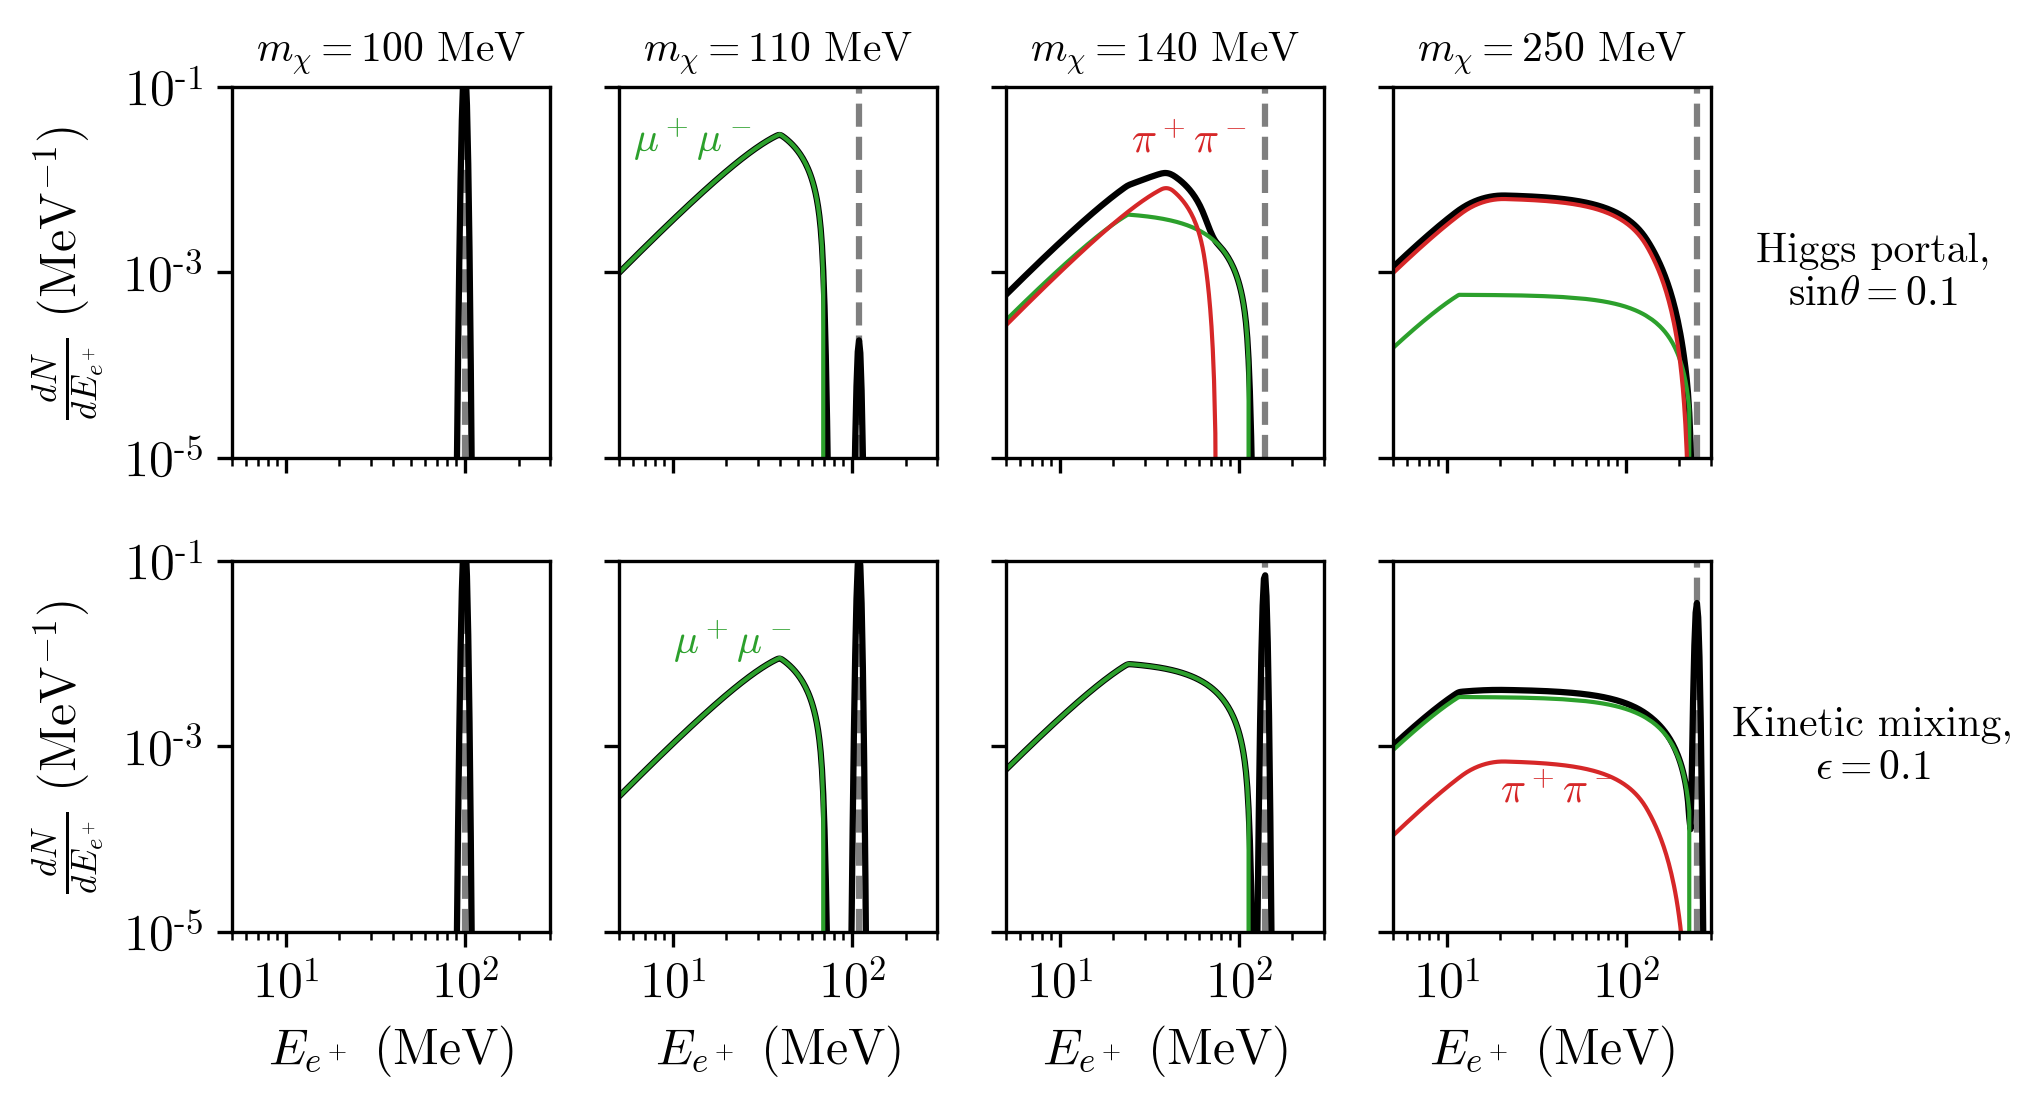

In [3]:
fig, axes = plt.subplots(
    n_subplot_rows,
    n_subplot_cols,
    sharex=True,
    sharey=True,
    figsize=(latex_text_width_1col, 0.55 * latex_text_width_1col),
)

for row in range(n_subplot_rows):  # loop over type of model
    for col in range(n_subplot_cols):  # loop over DM masses
        ax = axes[row, col]

        # Get the model and set DM mass to column's value
        model = models[row]
        model.mx = mxs[col]
        # DM center of mass energy
        e_cm = 2.0 * model.mx * (1.0 + 0.5 * vx_mw ** 2)

        # Get function to compute total convolved spectrum
        dnde_det_fn = model.total_conv_positron_spectrum_fn(
            e_p_min, e_p_max, e_cm, energy_res=energy_res_comptel
        )
        # Evaluate and plot
        ax.loglog(e_ps, dnde_det_fn(e_ps), "k")

        # Plot individual channels' continuum spectra
        for fs, spec in model.positron_spectra(e_ps, e_cm).items():
            if fs != "total":
                ax.loglog(
                    e_ps,
                    spec,
                    color=get_color(fs),
                    linewidth=1,
                    label=get_tex_label(fs),
                )

        # Compute line energies
        for fs, line_info in model.positron_lines(e_cm).items():
            ax.axvline(
                line_info["energy"], linestyle="--", color="k", alpha=0.5, linewidth=1.5
            )

        # Formatting: label final states
        for fs, (x, y) in fs_labels[row, col].items():
            ax.text(x, y, get_tex_label(fs), fontsize=10, color=get_color(fs))

# Formatting
for row in range(n_subplot_rows):
    axes[row, 0].set_ylabel(r"$\frac{dN}{dE_{e^+}}$ (MeV$^{-1}$)")
    axes[row, 0].set_ylim(1e-5, 1e-1)

for col in range(n_subplot_cols):
    axes[0, col].set_title(r"$m_\chi = %i$ MeV" % mxs[col], fontsize=10)
    axes[-1, col].set_xlabel(r"$E_{e^+}$ (MeV)")
    axes[-1, col].set_xlim(e_p_min, e_p_max)

axes[0, -1].text(
    2.4e3,
    1e-3,
    "Higgs portal,\n" + r"$\sin\theta = 0.1$",
    ha="center",
    va="center",
    fontsize=10,
)
axes[1, -1].text(
    2.4e3,
    1e-3,
    "Kinetic mixing,\n" + r"$\epsilon = 0.1$",
    ha="center",
    va="center",
    fontsize=10,
)

fig.tight_layout()
fig.savefig("figures/positron_spectra_ann_to_sm.pdf", bbox_inches="tight")
plt.show()